In [1]:
import numpy as np
import cv2
import os
import shutil
import time
import random
import matplotlib.pyplot as plt
import math
from PIL import Image
from PIL.ExifTags import TAGS
import xml.etree.ElementTree as ET

In [106]:
def get_image_coordinate(path):
    im=Image.open(path)
    #info_dict = {
    #"Filename": im.filename,
    #"Image Size": im.size,
    #"Image Height": im.height,
    #"Image Width": im.width,
    #"Image Format": im.format,
    #"Image Mode": im.mode,
    #"Image is Animated": getattr(im, "is_animated", False),
    #"Frames in Image": getattr(im, "n_frames", 1)
    #}
    #exif_list=[]
    exifdata = im.getexif()
    for tag_id in exifdata:
        # get the tag name, instead of human unreadable tag id
        tag = TAGS.get(tag_id, tag_id)
        data = exifdata.get(tag_id)
        # decode bytes 
        
        if isinstance(data, bytes):
            try:
                data = data.decode()
            except:
                continue
        print(f"{tag:25}: {data}")
        #print(f"{hex(tag_id)}: {tag:25}: {data}")
        if tag == "XMLPacket":
            print(f"{tag:25}: {data}")
            return data
    #    exif_list.append(data)
    #    im.getexif().get_ifd(0x8825)
    return 0
path='C:/ausm/phaseone/IMG_MM000XXX_2021-05-12_18-44-55.571_6809.tif'
xmlexif=get_image_coordinate(path)
root = ET.fromstring(xmlexif)
#print(type(root))
#print(root.tag)
#print(root.attrib)
for child in root:
    break
    #print(child.tag)
    #print(child.attrib)
print(root[0][0].attrib)
xml_dict=root[0][0].attrib
#print(xml_dict['{http://ns.adobe.com/exif/1.0/}GPSLongitude'])
#print(xml_dict['{http://ns.adobe.com/exif/1.0/}GPSLatitude'])
long=xml_dict['{http://ns.adobe.com/exif/1.0/}GPSLongitude']
lat=xml_dict['{http://ns.adobe.com/exif/1.0/}GPSLatitude']
long_ddmm=long.split(',')
#print(long_ddmm[0]+" "+long_ddmm[1][:-1])
lat_ddmm=lat.split(',')
#print(lat_ddmm[0]+" "+lat_ddmm[1][:-1])
print("Image:",xml_dict['{http://ns.adobe.com/exif/1.0/aux/}ImageNumber'])
print("lat, long (DD.dd):",f"{float(lat_ddmm[0])+float(lat_ddmm[1][:-1])/60}, {-1*(float(long_ddmm[0])+float(long_ddmm[1][:-1])/60)}")


ImageWidth               : 14204
ImageLength              : 10652
BitsPerSample            : (8, 8, 8)
Compression              : 1
PhotometricInterpretation: 2
Make                     : Phase One
Model                    : iXM-RS150F
StripOffsets             : (8, 8181512, 16363016, 24544520, 32726024, 40907528, 49089032, 57270536, 65452040, 73633544, 81815048, 89996552, 98178056, 106359560, 114541064, 122722568, 130904072, 139085576, 147267080, 155448584, 163630088, 171811592, 179993096, 188174600, 196356104, 204537608, 212719112, 220900616, 229082120, 237263624, 245445128, 253626632, 261808136, 269989640, 278171144, 286352648, 294534152, 302715656, 310897160, 319078664, 327260168, 335441672, 343623176, 351804680, 359986184, 368167688, 376349192, 384530696, 392712200, 400893704, 409075208, 417256712, 425438216, 433619720, 441801224, 449982728)
Orientation              : 1
SamplesPerPixel          : 3
RowsPerStrip             : 192
StripByteCounts          : (8181504, 8181504, 818150

In [2]:
def p1_to_deepglobe(path):
    """
    Given path to an image
    Return list of 1024x1024 crops
    """
    #path="C:/ausm/phaseone/labels/IMG_MM000XXX_2021-05-12_18-10-35.997_6661.tif"
    img=cv2.imread(path)
    S=0.1442047376
    img=cv2.resize(img,None,fx=S,fy=S)
    return [img[:1024,:1024],img[:1024,-1024:],img[-1024:,:1024],img[-1024:,-1024:]]
#for i,im in enumerate(imgs):
#    cv2.imwrite("C:/ausm/phaseone/labels/"+str(i)+".png",im)

#plt.imshow(img)
#cv2.imwrite("C:/ausm/phaseone/labels/test.png",img)

    
    
    
def phaseone_to_crops(path):
    """
    Given path to an image
    Return list of 1024x1024 crops
    """
    
    #img=cv2.imread("C:/ausm/phaseone/IMG_MM000XXX_2021-05-12_18-44-55.571_6809.tif")
    img=cv2.imread(path)
    #plt.imshow(img)
    S=0.16 #DeepGlobe scale factor
    #print(min(img.shape[:2]))
    W=min(img.shape[:2])

    X1=S*W
    #print(X1)
    n0=X1/1024
    n1=math.floor(n0)
    if n0-n1 < 0.5:
        n2=n1
        S2=S*(n2*1024)/X1
        #print("Objects on your dataset appear ", (n2*1024)/X1,"times smaller than on the DeepGlobe dataset")
    else:
        n2=n1+1
        S2=S*(n2*1024)/X1
        #print("Objects on your dataset appear ", (n2*1024)/X1,"times larger than on the DeepGlobe dataset")
    img=cv2.resize(img,None,fx=S2,fy=S2)
    #plt.imshow(img)
    #print(img.shape)
    #cols=list(range(math.ceil(max(img.shape)/1024)))
    #print(cols)
    crops=[]
    length=max(img.shape[:2])
    #print("hah",min(img.shape[:2])/1024)
    count=0
    for h in range(int(min(img.shape[:2])/1024)):
        for i in range(math.floor(max(img.shape[:2])/1024)):
            crops.append(img[h*1024:(h+1)*1024,i*1024:(i+1)*1024,:])
        crops.append(img[h*1024:(h+1)*1024,-1024:,:])
        

        
    #for crop in crops:
    #    print(crop.shape)
    return crops
    #print(img.shape)
    #plt.imshow(crops[5])





In [ ]:
outdir="C:/ausm/phaseone/resize/"
name="IMG_MM000XXX_2021-05-12_18-44-55.571_6809.tif"
ext=name.split(".")[-1]
print(ext)
crops=p1_to_deepglobe("C:/ausm/phaseone/"+name)

for i,crop in enumerate(crops):
    cv2.imwrite(outdir+"RSZ_"+name.removesuffix('.tif')+"_"+str(i)+".tif",crop)

In [53]:
import cv2
import numpy as np
import math


def crops_to_phaseone(path):
    """crops_to_phaseone(path) - for batch processing of """
    crops = os.listdir(path)
    isFirst = True
    isRoot = True
    for (root, dirs, files) in os.walk(path, topdown=True):
        if isRoot:
            for i, crop in enumerate(files):
                curr_file = crop[:41]
                # print(crop)
                if isFirst:
                    # print(len(crops))
                    isFirst = False
                    tile = np.zeros((10652, 14204, 3), dtype=np.uint8)
                    index = int(crop.split('_')[-2].split('_')[-1])
                    row = math.floor(index/4)
                    col = index-(row)*4
                    tile[row*2663:(row+1)*2663, col*3551:(col+1) *
                         3551, :] = cv2.imread(path+crop)
                    parent_file = crop[:41]
                    #print("New source image detected:", src)
                if curr_file == parent_file:
                    index = int(crop.split('_')[-2].split('_')[-1])
                    row = math.floor(index/4)
                    col = index-(row)*4
                    tile[row*2663:(row+1)*2663, col*3551:(col+1) *
                         3551, :] = cv2.imread(path+crop)
                else:
                    cv2.imwrite("C:/ausm/phaseone/labels/" +
                                parent_file+".tiff", tile)
                    parent_file = curr_file
                    tile = np.zeros((10652, 14204, 3), dtype=np.uint8)
                    index = int(crop.split('_')[-2].split('_')[-1])
                    row = math.floor(index/4)
                    col = index-(row)*4
                    tile[row*2663:(row+1)*2663, col*3551:(col+1) *
                         3551, :] = cv2.imread(path+crop)
                if i == len(files)-1:
                    cv2.imwrite("C:/ausm/phaseone/labels/" +
                                parent_file+".tiff", tile)
        isRoot = False
        break
        # tile[row*2663:(row+1)*2663, col*3551:(col+1) *
        #     3551, :] = cv2.imread(path+crop)

#

        #print(crop+f"/t{row}, {col}")
        # print(len(crops))

        # print(crop)


#crops_to_phaseone(
#    "C:/Users/yenja/Downloads/196795_batch1/ds0/masks_instances/")


In [54]:

#TODO after testing if padding is worth
def square_pad(path):
    if os.path.isfile(path):
        img=cv2.imread(path)
        
    #elif os.path.isdir(path):
        
def dlinknet_resize(path):
    img=cv2.imread(path)
    #print(img.shape)
    N=math.floor(np.min(np.array(img.shape[0:1]))/32)*32
    #print(N)
    img=cv2.resize(img,(1024,1024))
    return img
    

    
    
def find_unique(master,sub):
    
    unique=[]
    #for i,m in enumerate(master):
    #    master[i]=master[i].split(".")[0]
    #master=master
    inst1=""
    for i,m in enumerate([m[:41] for m in master]):
        #print("==========")
        #print(m)
        is_unique=True
        for j,s in enumerate([s[:41] for s in sub]):
            #print("----------")
            #if
            #print("/t"+s)
            if m in s:
                is_unique=False
                break
        if is_unique:
            unique.append(master[i])
    return unique

def find_files_by_extension(folder,ext):
    f_ext=[]
    files=os.listdir(folder)
    for f in files:
        if os.path.isfile(folder+f) and ext in f[-5:]:
            f_ext.append(f)
    return f_ext

def merge_labels(path):
    for (root, dirs, files) in os.walk(path, topdown=True):
        #print("The root is: ")
        #print(root)
        #print("The directories are: ")
        #print(dirs)
        #print("The files are: ")
        #print(files)
        #print('--------------------------------')
        if ".tif" in root:
            #print(len(files)-1)
            for i,name in enumerate(files):
                #print(root+"/"+name)
                #print(name)
                if i==0:
                    if "Parking Aisle" in name or "Service Road" in name:
                        merge=np.zeros([2663,3551,3])
                        continue
                    else:
                        merge=cv2.imread(root+"/"+name)
                else:
                    if "Parking Aisle" in name or "Service Road" in name:
                        pass
                        # continue
                    #img=cv2.imread(root+"/"+name)
                    else:
                        merge+=cv2.imread(root+"/"+name)
                if i==(len(files)-1):
                    if "Parking Aisle" in name or "Service Road" in name:
                        imgname=root.split("//")[-1]
                        #print(imgname)
                        imgname=imgname[:-4]+"_label.png"
                        #print(imgname)
                        merge[merge>=128]=255
                        merge[merge<128]=0
                        cv2.imwrite(imgname,merge.astype(np.uint8))
                    #img=cv2.imread(root+"/"+name)
                    else:
                        merge+=cv2.imread(root+"/"+name)
                        imgname=root.split("//")[-1]
                        #print(imgname)
                        imgname=imgname[:-4]+"_label.png"
                        #print(imgname)
                        merge[merge>=128]=255
                        merge[merge<-128]=0
                    #print(root+"/"+imgname)
                        cv2.imwrite(imgname,merge.astype(np.uint8))
                        


        #print("The root is: ")
        #print(root)
        #print("The directories are: ")
        #print(dirs)
        #print("The files are: ")
        #print(files)
        #print('--------------------------------')

def square_tile(img,N):
    #img=cv2.imread(p)
    (H,W,D)=img.shape
    nh=(int(H/N)+1)
    nw=(int(W/N)+1)
    h=nh*N
    w=nw*N
    padded=255*np.ones([h,w,D],dtype=np.uint8)
    #print(img.shape)
    #print(padded.shape)
    padded[:H,:W,:]=img
    #plt.imshow(padded)
    count=0
    tile=[]#np.zeros([1024,1024],dtype=np.uint8)
    temp=np.zeros([1024,1024,3],dtype=np.uint8)
    #print(padded.shape)
    for i in range(1024,h+1,1024):
        for j in range(1024,w+1,1024):
            print(f'{j},{i}',end="/t")
            temp[:]=padded[(i-1024):i,(j-1024):j,:]
            tile.append(temp)
            print(tile[count].shape)
            count+=1
        #print("")
            #
        #padded=padded[-1024:,-1024:,:]
        #plt.imshow(padded)
        #plt.hist(np.reshape(padded,[1,padded.size]))
    return tile

        
        
            


In [55]:
paths=("C:/Users/yenja/Downloads/batch1/ds0/masks_instances/",
       "C:/Users/yenja/Downloads/batch2/ds0/masks_instances/",
       "C:/Users/yenja/Downloads/batch3/ds0/masks_instances/",
       "C:/Users/yenja/Downloads/batch4/ds0/masks_instances/",
       "C:/Users/yenja/Downloads/batch5/ds0/masks_instances/",
       "C:/Users/yenja/Downloads/batch6/ds0/masks_instances/")

path=paths[3]
merge_labels(path)
crops_to_phaseone(path)


In [51]:
            
mfolder= 'C:/ausm/phaseone/'
sfolder= 'C:/ausm/phaseone/tile/'
master=os.listdir(mfolder)
sub=os.listdir(sfolder)


mtifs=find_files_by_extension(mfolder,".tif")
stifs=find_files_by_extension(sfolder,".tif")
unique_tifs=find_unique(mtifs,stifs)
#stifs_no_ext=[s[:41] for s in stifs]
#mtifs_no_ext=[m[:41] for m in mtifs]
#print(stifs)
#print(len(mtifs))
#print(len(stifs))

#print(unique_tifs)
unique_tifs=random.choices(unique_tifs,k=13)
print([mfolder+u for u in unique_tifs[:3]])




#print(os.path.isdir(mfolder+'resize'))
print(int(1.51))
for path in [mfolder+u for u in unique_tifs[:1]]:
    img=cv2.imread(path)
    img=img[:1333,:1333,:]
    tile=square_tile(img,1024)
    #print(tile)
    for t in tile:
        print(t.shape)
        #plt.imshow(t)
#plt.imshow(img[:1333,:1333,:])
#plt.imshow(tile[0])
#plt.hist(np.reshape(tile[0],[1,tile[0].size]))

NameError: name 'random' is not defined

In [ ]:
if False:
    print('fuck')
    path='C:/Users/yenja/Downloads/196795_batch1/ds0/masks_instances/'
    try:
        shutil.rmtree(path+"merge")
        os.makedirs(path+"merge")
    except:
        pass
    merge_labels(path,path+"merge/")


test=False
if test:
    path="C:/dataset/massachussets/tiff/train/10378690_15.tiff"
    #img=cv2.imread(path)
    img=dlinknet_resize(path)
    print(img.shape)
    #plt.imshow(img)
    
    #print(type(np.array(img.shape)))
    #print(np.max(np.array(img.shape)))
    
    #square_pad()

In [5]:
#folder="C:/ausm/phaseone/"
#folder="C:/ausm/road/Road-Extraction-master/Road-Extraction-master/massachussets/tiff/train/"
folder="C:/dataset/massachussets/tiff/train/"
source=os.listdir(folder)
target=folder+"resize/"
try:
    os.mkdir(target)
except:
    pass
t=time.time()
for i,name in enumerate(source):
    #print(name)
    if os.path.isfile(folder+name) and ".tiff" in name:
        #print(name)
        #print(i)
        img=dlinknet_resize(folder+name)
        cv2.imwrite(target+name[:-5]+"_rsz.tif",img)
        
print(time.time()-t)
        
        
        
        

(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1500, 3)
(1500, 1

In [4]:

#path="C:/ausm/phaseone/infer"
def image_cropped_resize(path,outpath):
    
    files=os.listdir(path)
    #print(files)
    files=list(filter(lambda x: x.endswith('.tif') or x.endswith('.tiff'),files))
    #files=list(filter(lambda x: x.endswith('.tiff'),files))
    try:
        pass
        #os.makedirs(os.path.join(path,'resize'))
    except:
        pass
    for file in files:
        #pass
        resizes=p1_to_deepglobe(os.path.join(path,file))
        for i,r in enumerate(resizes):
            if np.sum(r)>0:
                (pre,sep,suf)=file.rpartition('.')
                #print(os.path.join(path,'resize','RSZ_'+pre+'_'+str(i)+sep+suf))
                cv2.imwrite(os.path.join(outpath,'RSZ_'+pre+'_'+str(i)+sep+suf),r)
            else:
                print(pre,str(i),"\nLabel with no roads detected and omitted")
        #print(r.shape)
        #break
    
    

In [5]:
path='C:/ausm/phaseone/infer'
#path='C:/ausm/phaseone/labels'
try:
    os.makedirs(os.path.join(path,'resize'))
except:
    pass
image_cropped_resize(path,os.path.join(path,'resize'))
#fun=p1_to_deepglobe("C:/ausm/phaseone/labels/IMG_MM000XXX_2021-05-12_18-37-53.441_6772.tiff")
#plt.imshow(fun[0])

In [180]:
import shutil
orig_path="C:/ausm/phaseone/"

label_path="C:/ausm/phaseone/labels/"
label_files=os.listdir(label_path)
#print(label_files)
labels=list(filter(lambda x: x.endswith(".tiff"),label_files))
#print(labels)
images=list(filter(lambda x: x.endswith(".tif"),label_files))
prefix=list(map(lambda x: x[:41],labels))
#print(prefix)
orig_files=os.listdir(orig_path)
inferpath='C:/ausm/phaseone/infer/'
try:
    os.makedirs(inferpath)
except:
    pass
isLabelled=False
for o in orig_files:
    #print(o)
    isLabelled=False
    for p in prefix:
        #print(p)
        if p in o:
            isLabelled=True
            break
    if isLabelled==False and os.path.isfile(orig_path+o):
        try:
            pass
            #shutil.copy(orig_path+o,inferpath+o)
        except:
            pass
        
random.seed(230)
#print(prefix)
random.shuffle(prefix)
#print(prefix)

split1_index=int(0.6*len(prefix))
split2_index=int(0.8*len(prefix))
train=prefix[:split1_index]
test=prefix[split1_index:split2_index]
valid=prefix[split2_index:]
print(len(train))
try:
    os.makedirs(os.path.join(label_path,'test'))
    os.makedirs(os.path.join(label_path,'train'))
    os.makedirs(os.path.join(label_path,'test_labels'))
    os.makedirs(os.path.join(label_path,'train_labels'))
    os.makedirs(os.path.join(label_path,'valid'))
    os.makedirs(os.path.join(label_path,'valid_labels'))

except:
    pass
for tr in train:
    #print("train",tr)
    print('train',tr)
    for l in label_files:
        #print(l)
        #break
        if tr in l and l.endswith('.tif'):
            #print(tr)
            print(l)
            shutil.copy(os.path.join(label_path,tr+'.tif'),os.path.join(label_path,'train',tr+'.tif'))
        elif tr in l and l.endswith('.tiff'):
            #print(tr)
            print(l)
            shutil.copy(os.path.join(label_path,tr+'.tiff'),os.path.join(label_path,'train_labels',tr+'.tiff'))
for tr in test:
    #print("test",tr)
    print('test',tr)
    for l in label_files:
        #print(l)
        #break
        if tr in l and l.endswith('.tif'):
            #print(tr)
            print(l)
            shutil.copy(os.path.join(label_path,l),os.path.join(label_path,'test',l))
        elif tr in l and l.endswith('.tiff'):
            #print(tr)
            print(l)
            shutil.copy(os.path.join(label_path,l),os.path.join(label_path,'test_labels',l))
for tr in valid:
    #print("test",tr)
    print('valid',tr)
    for l in label_files:
        #print(l)
        #break
        if tr in l and l.endswith('.tif'):
            #print(tr)
            print(l)
            shutil.copy(os.path.join(label_path,l),os.path.join(label_path,'valid',l))
        elif tr in l and l.endswith('.tiff'):
            #print(tr)
            print(l)
            shutil.copy(os.path.join(label_path,l),os.path.join(label_path,'valid_labels',l))
            





        
            

#print(images)
#print(files)


16
train IMG_MM000XXX_2021-05-12_18-37-53.441_6772
IMG_MM000XXX_2021-05-12_18-37-53.441_6772.tif
IMG_MM000XXX_2021-05-12_18-37-53.441_6772.tiff
train IMG_MM000XXX_2021-05-12_18-28-50.947_6730
IMG_MM000XXX_2021-05-12_18-28-50.947_6730.tif
IMG_MM000XXX_2021-05-12_18-28-50.947_6730.tiff
train IMG_MM000XXX_2021-05-12_18-28-06.931_6723
IMG_MM000XXX_2021-05-12_18-28-06.931_6723.tif
IMG_MM000XXX_2021-05-12_18-28-06.931_6723.tiff
train IMG_MM000XXX_2021-05-12_18-11-22.346_6668
IMG_MM000XXX_2021-05-12_18-11-22.346_6668.tif
IMG_MM000XXX_2021-05-12_18-11-22.346_6668.tiff
train IMG_MM000XXX_2021-05-12_18-44-55.571_6809
IMG_MM000XXX_2021-05-12_18-44-55.571_6809.tif
IMG_MM000XXX_2021-05-12_18-44-55.571_6809.tiff
train IMG_MM000XXX_2021-05-12_18-14-15.576_6684
IMG_MM000XXX_2021-05-12_18-14-15.576_6684.tif
IMG_MM000XXX_2021-05-12_18-14-15.576_6684.tiff
train IMG_MM000XXX_2021-05-12_18-35-31.833_6760
IMG_MM000XXX_2021-05-12_18-35-31.833_6760.tif
IMG_MM000XXX_2021-05-12_18-35-31.833_6760.tiff
train IMG_

In [186]:
try:
    out_path="C:/ausm/phaseone/upload/"
    os.makedirs(os.path.join(out_path,'test'))
    os.makedirs(os.path.join(out_path,'train'))
    os.makedirs(os.path.join(out_path,'test_labels'))
    os.makedirs(os.path.join(out_path,'train_labels'))
    os.makedirs(os.path.join(out_path,'valid'))
    os.makedirs(os.path.join(out_path,'valid_labels'))
except:
    pass
paths = ["C:/ausm/phaseone/labels/test_labels",
         "C:/ausm/phaseone/labels/train_labels",
         "C:/ausm/phaseone/labels/test",
         "C:/ausm/phaseone/labels/train",
         "C:/ausm/phaseone/labels/valid_labels",
         "C:/ausm/phaseone/labels/valid"]
outpaths = ["C:/ausm/phaseone/upload/test_labels",
         "C:/ausm/phaseone/upload/train_labels",
         "C:/ausm/phaseone/upload/test",
         "C:/ausm/phaseone/upload/train",
         "C:/ausm/phaseone/upload/valid_labels",
         "C:/ausm/phaseone/upload/valid"]
for i in range(len(paths)):
    print(outpaths[i])
    image_cropped_resize(paths[i],outpaths[i])


C:/ausm/phaseone/upload/test_labels
C:/ausm/phaseone/upload/train_labels
IMG_MM000XXX_2021-05-12_18-14-15.576_6684 2 
Label with no roads detected and omitted
IMG_MM000XXX_2021-05-12_18-37-53.441_6772 3 
Label with no roads detected and omitted
IMG_MM000XXX_2021-05-12_18-41-57.139_6795 0 
Label with no roads detected and omitted
IMG_MM000XXX_2021-05-12_18-44-55.571_6809 2 
Label with no roads detected and omitted
IMG_MM000XXX_2021-05-12_18-44-55.571_6809 3 
Label with no roads detected and omitted
C:/ausm/phaseone/upload/test
C:/ausm/phaseone/upload/train
C:/ausm/phaseone/upload/valid_labels
C:/ausm/phaseone/upload/valid


1.1624836998110024


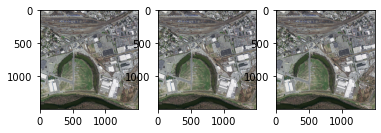

In [168]:
import data_aug as d
import torchvision.transforms.functional as TF
import random
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import torch

image=Image.open(
    Path("C:/dataset/massachussets/tiff/test/10828720_15.tiff"))
image, segmentation = d.segmentation_randscale(image,image)

f, axarr = plt.subplots(1, 3)
axarr[0].imshow(TF.to_pil_image(image))
axarr[1].imshow(TF.to_pil_image(image))
axarr[2].imshow(TF.to_pil_image(segmentation))